In [ ]:
import pandas_gbq
import pandas as pd
import requests

import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)

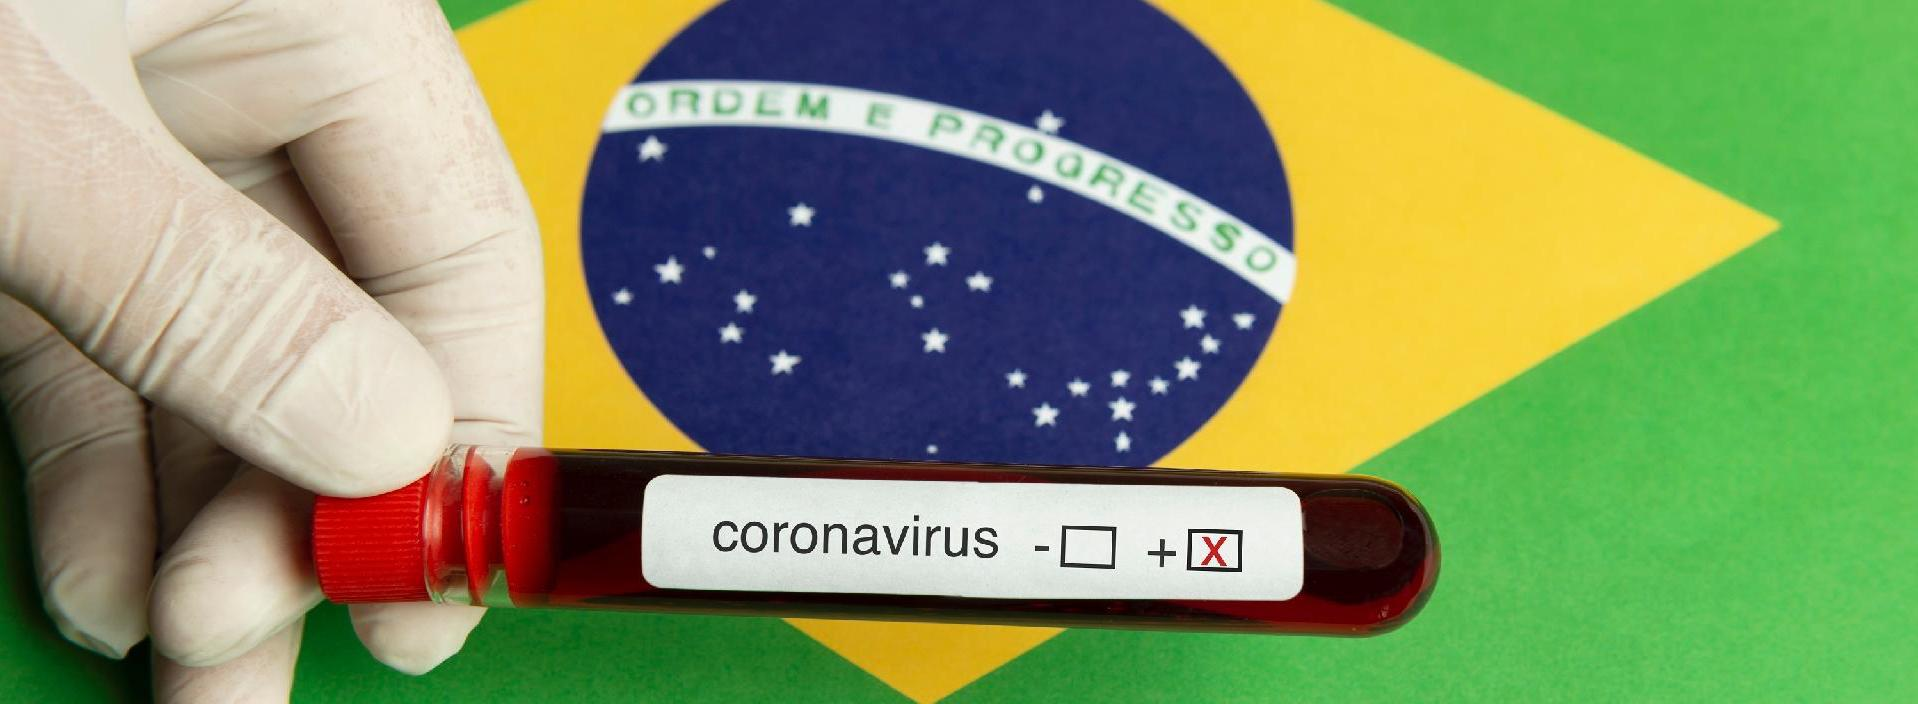

# Modelo SIRD - seus resultados

O modelo SIRD tem o seguinte formato:

$$ \frac{dS(t)}{dt} = - \frac{\beta S(t)I(t)}{N} $$
$$ \frac{dI(t)}{dt} = \frac{\beta S(t)I(t)}{N} - r I(t) - \mu I(t) $$
$$ \frac{dR(t)}{dt} = r I(t) $$
$$ \frac{dD(t)}{dt} = \mu I(t) $$

Aplicando nosso algoritmo de aprendizagem heurística, conseguimos extrair os seguintes parâmetros para o modelo:
- $R_o = @$Ro$@$, esse é o número básico de reprodução, que mede quantas pessoas um infectado, em média, infecta.
- $D = @$D$@$, esse é o tempo de recuperação em dias, considerado pelo sistema de saúde.
- $\mu = @$mu$@$, esse é o coeficiente de mortalidade e informa a proporção de mortes diária.
- $pop = @$pop$@$, esse é a proporção estimada da sua população que atenderá ao sistema de saúde.

Você pode recuperar os parâmetros do modelo a partir das seguintes relações:

$$r = 1/D$$ 
$$\beta = \frac{R_o r}{\text{pop}}$$

levando a $r = @$r$@$ e $\beta = @$beta$@$.

In [ ]:
r = 1 / @$D$@
beta = @$pop$@ * r / @$Ro$@
# print(f"Seu parâmetro beta: {beta}")
# print(f"Seu parâmetro r: {r}")

Você também pode analisar a qualidade das previsões de nosso algoritmo, comparando-as com os dados reais coletados de sua região de análise:

In [ ]:
# Adiquirindo os dados e previsões
user_id = '@$user_id$@'
minha_api = 'https://visual-data-dot-epidemicapp-280600.rj.r.appspot.com'
predicao_api = minha_api + '/predictions?id=' + user_id
dados_reais_api = minha_api + '/real_data?id=' + user_id

r1 = requests.get(predicao_api)
predicao = pd.DataFrame(r1.json())

r2 = requests.get(dados_reais_api)
dados_reais = pd.DataFrame(r2.json())

# Plottando os resultados
fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Previsão - Casos Ativos",
    x=predicao["date"],
    y=predicao['active'],
    mode='lines', line_shape='spline',
    line=dict(width=3, color = '#fb8c00')))
fig.add_trace(go.Scatter(
    name="Previsão - Mortes",
    x=predicao["date"],
    y=predicao['deaths'],
    mode='lines', line_shape='spline',
    line=dict(width=3, color = '#e53935')))
fig.add_trace(go.Scatter(
    name="Previsão - Recuperados",
    x=predicao["date"],
    y=predicao['recovered'],
    mode='lines', line_shape='spline',
    line=dict(width=3, color = '#43a047')))

fig.add_trace(go.Scatter(
    name="Dados - Casos Ativos",
    x=dados_reais["date"],
    y=dados_reais['active'],
    mode='markers', line_shape='spline',
    line=dict(width=3, color = '#c25e00')))
fig.add_trace(go.Scatter(
    name="Dados - Mortes",
    x=dados_reais["date"],
    y=dados_reais['deaths'],
    mode='markers', line_shape='spline',
    line=dict(width=3, color = '#ab000d')))
fig.add_trace(go.Scatter(
    name="Dados - Recuperados",
    x=dados_reais["date"],
    y=dados_reais['recovered'],
    mode='markers', line_shape='spline',
    line=dict(width=3, color = '#00701a')))

fig.update_layout(
    template='xgridoff',
    xaxis_title='Date',
    title_text="Previsão das componentes principais do modelo SIRD")

fig.show(renderer="png")

## Calculando o seu valor de $R_t$

$R_t$ nada mais é que o valor de reprodução da sua epidemia ao longo do tempo. Esse parâmetro é de imenso interesse uma vez que, se $R_t$ for menor do que $1$, sabemos que a epidemia está em processo de estabilização, e não tem força para continuar crescendo; caso $R_t$ for maior do que $1$, sabemos que a epidêmia ainda está crescendo e tem força para manter seu padrão de evolução. Deste modo, para seus dados, podemos calcular o $R_t$ da seguinte forma:

In [ ]:

import numpy as np

window_size = 5  # Tamanho da janela de estimação em dias

Likeli = list()
R_t_dados, data_dados = list(), list()
for k in range(0, len(dados_reais) - window_size):
    next_k = k + window_size
    C_now  = dados_reais["active"].iloc[k]
    C_next = dados_reais["active"].iloc[next_k]
    at_time = dados_reais["date"].iloc[k]
    R_t_dados.append(C_next / C_now)
    data_dados.append(at_time)
    
#     if k > 1:
#         acc = 0.95
#         for i in range(k-1):
#             C_i = dados_reais["active"].iloc[i]
#             C_n = dados_reais["active"].iloc[i+window_size]
#             acc = acc * (C_i * R_t_dados[i])**C_n * np.exp(-C_i*R_t_dados[i])
#         Likeli.append( acc )
        
R_t_modelo, data_modelo = list(), list()
for k in range(0, len(predicao) - window_size):
    next_k = k + window_size
    C_now  = predicao["active"].iloc[k]
    C_next = predicao["active"].iloc[next_k]
    at_time = predicao["date"].iloc[k]
    R_t_modelo.append(C_next / C_now)
    data_modelo.append(at_time)

# Plotando o valor do Rt
fig = go.Figure()

fig.add_trace(go.Scatter(
    name="Valor de R_t - Dados",
    x=data_dados,
    y=R_t_dados,
    mode='lines', 
    line=dict(width=3)))
fig.add_trace(go.Scatter(
    name="Valor de R_t - Modelo",
    x=data_modelo[:len(data_dados)],
    y=R_t_modelo[:len(data_dados)],
    mode='lines', 
    line=dict(width=3)))

# fig.add_trace(go.Scatter(
#     name="Likelihood 95% - Estimativa dos dados",
#     x=data_dados[1:],
#     y=Likeli,
#     mode='lines', 
#     line_shape='spline',
#     line=dict(width=2, dash="dash")))

fig.update_layout(
    template='xgridoff',
    xaxis_title='Data',
    title_text="Analisando o Rt ao longo do tempo")

fig.show(renderer="png")

# Comparando seus resultados com o resto do Brasil

Comparando os seus resultados com todas as regiões do Brasil, nós podemos comparar seus parâmetros com os parâmetros de cada estado e verificar o quão próximo seus dados está de cada região:

In [ ]:

# Obtendo os parâmetros de cada estado
parametros_api = minha_api + '/state_parameters'

r3 = requests.get(parametros_api)
est_pars_df = pd.DataFrame(r3.json())
est_lista = est_pars_df["state"].unique().tolist()

# Parametros estimados
R_o = @$Ro$@     # Número básico de reprodução
D   = @$D$@      # Tempo de recuperação
pop = @$pop$@    # Proporção da população que atenderá ao sistema de saúde
mu  = @$mu$@     # Taxa de mortalidade diária dos infectados

# Criando a lista de valores para todos os estados
R_o = [R_o] * len(est_lista)
D   = [D]   * len(est_lista)
pop = [pop] * len(est_lista)
mu  = [mu]  * len(est_lista)

# Plotando os parâmetros
fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Parametro Ro para cada estado",
    x=est_pars_df["state"],
    y=est_pars_df["Ro"],
    mode='lines', 
    line=dict(width=5)))
fig.add_trace(go.Scatter(
    name="Seu valor estimado de Ro",
    x=est_lista,
    y=R_o,
    mode='lines', 
    line=dict(width=3, dash="dash")))

fig.update_layout(
    template='xgridoff',
    title_text="Comparação Ro: número de pessoas que uma infectará")
fig.show(renderer="png")


fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Parametro D para cada estado",
    x=est_pars_df["state"],
    y=est_pars_df["D"],
    mode='lines', 
    line=dict(width=5)))
fig.add_trace(go.Scatter(
    name="Seu valor estimado de D",
    x=est_lista,
    y=D,
    mode='lines', 
    line=dict(width=3, dash="dash")))

fig.update_layout(
    template='xgridoff',
    title_text="Comparação D: tempo de recuperação")
fig.show(renderer="png")

fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Parametro Pop para cada estado",
    x=est_pars_df["state"],
    y=est_pars_df["pop"],
    mode='lines', 
    line=dict(width=5)))
fig.add_trace(go.Scatter(
    name="Seu valor estimado de Pop",
    x=est_lista,
    y=pop,
    mode='lines', 
    line=dict(width=3, dash="dash")))

fig.update_layout(
    template='xgridoff',
    title_text="Comparação Pop: proporção da população que atenderá ao sistema de saúde")
fig.show(renderer="png")


fig = go.Figure()
fig.add_trace(go.Scatter(
    name="Parametro mu para cada estado",
    x=est_pars_df["state"],
    y=est_pars_df["mu"],
    mode='lines', 
    line=dict(width=5)))
fig.add_trace(go.Scatter(
    name="Seu valor estimado de mu",
    x=est_lista,
    y=mu,
    mode='lines', 
    line=dict(width=3, dash="dash")))

fig.update_layout(
    template='xgridoff',
    title_text="Comparação mu: taxa de mortalidade diária dos infectados")
fig.show(renderer="png")

## Seu modelo...

A partir dos dados, temos as seguintes equações para o seus dados:

$$ \frac{dS(t)}{dt} = - \frac{@$beta$@ S(t)I(t)}{N} $$
$$ \frac{dI(t)}{dt} = \frac{@$beta$@ S(t)I(t)}{N} - @$r$@ I(t) - @$mu$@ I(t) $$
$$ \frac{dR(t)}{dt} = @$r$@ I(t) $$
$$ \frac{dD(t)}{dt} = @$mu$@ I(t) $$

